<a href="https://colab.research.google.com/github/MarZaj1278/SomeDSstuff/blob/master/Classification_Using_TransferLearnin_Upl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification using Transfer Learning
## Multiclass Image Classification 
### Dataset available of Kaggle

In [0]:
# Here, I develop and train an image classification CNN using an Intel Image Classification dataset 
# The information about the dataset as well as the dataset itself can be found under the following link
# https://www.kaggle.com/puneet6060/intel-image-classification

# Now import needed packages
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

**Download the dataset from Kaggle and unzip it**

In [0]:
# Download the full dataset from Kaggle.
# Use your Kaggle tocken that can be downlaoded via: www.kaggle.com -> Your Account -> Create New API token 

os.environ['KAGGLE_USERNAME'] = "XXX" # username from the json file
os.environ['KAGGLE_KEY'] = "YYY" # key from the json file
!kaggle datasets download -d puneet6060/intel-image-classification # api copied from kaggle

 99% 344M/346M [00:02<00:00, 158MB/s]
100% 346M/346M [00:02<00:00, 133MB/s]


In [0]:
# Unzip the zip-file

local_zip = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


**Do some data preprocessing**

In [0]:
# See how many files are inside

TRAINING_DIR = "/content/seg_train/seg_train/"
training_dir_list = os.listdir(TRAINING_DIR)

number_of_items_train = 0
for item in training_dir_list:
  path = os.path.join(TRAINING_DIR, item) 
  number_of_items_train = number_of_items_train + len(os.listdir(path))

VALIDATION_DIR = "/content/seg_test/seg_test/"
validation_dir_list = os.listdir(VALIDATION_DIR)

number_of_items_val = 0
for item in validation_dir_list:
  path = os.path.join(VALIDATION_DIR, item)       
  number_of_items_val = number_of_items_val + len(os.listdir(path))

print("Number of train data: " + str(number_of_items_train))
print("Number of validation data: " + str(number_of_items_val))
print("Number of test data: " + str(len(os.listdir('/content/seg_pred/seg_pred/'))))


Number of train data: 14034
Number of validation data: 3000
Number of test data: 7301


In [0]:
# Do some data preprocessing using data augmentation

# Train data
TRAINING_DIR = "/content/seg_train/seg_train/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True) 	   

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size = (150, 150),    # resize the figures to 150 x 150 pixels if not yet happened
	class_mode='categorical')

# Validation data
VALIDATION_DIR = "/content/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size = (150, 150),   # resize the figures to 150 x 150 pixels if not yet happened
	class_mode='categorical')

# Test data
TEST_DIR = "/content/seg_pred/"
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
	target_size = (150, 150),    # resize the figures to 150 x 150 pixels if not yet happened
	class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


**Do the training**

In [0]:
# Load pretrained model called InceptionV3 as well as the pretrained weigths

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-03-31 22:30:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  74.5MB/s    in 1.1s    

2020-03-31 22:30:53 (74.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Define the attachment to the pretrained model that does the classification
# Then, combine the pretrained model with the attachment to define the full model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.6)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(6, activation='softmax')(x)           

# Full model to be trained
model = Model( pre_trained_model.input, x) 

model.summary()

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
#optimizer=RMSprop(lr = 0.001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Define early stopping of the training prcess

ACCURACY_THRESHOLD = 0.95 

class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('acc') > ACCURACY_THRESHOLD):   
      print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
      self.model.stop_training = True

In [0]:
# Train the model

callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              verbose = 1,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator),
                              callbacks = [callbacks])
                             

Text(0.5, 1.0, 'Training and validation loss')

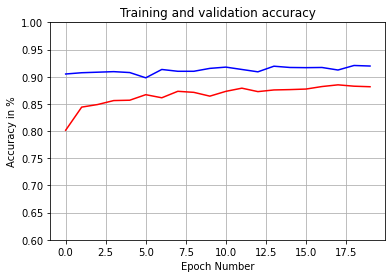

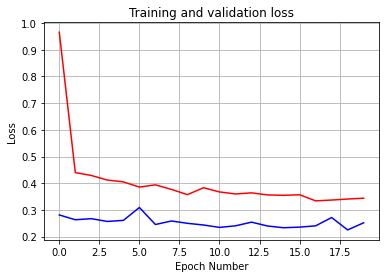

In [0]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r') #, "Training Accuracy")
plt.plot(epochs, val_acc, 'b') #, "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.grid()
plt.ylim((0.6,1))
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy in %')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r') #, "Training Loss")
plt.plot(epochs, val_loss, 'b')#, "Validation Loss")
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [0]:
# Run this cell if you want to retrieve the weigths of the layers
import numpy as np
for layer in model.layers:
    weights = np.array(layer.get_weights())
    print(layer.input)
    print(layer.output)



# Do some prediction now

In [0]:
# Determine the total number of batches and the number of images per batch in the test set 

num_batch = len(test_generator) 

test_batch = test_generator[0][0]
img_batch = test_batch.shape[0]


print('The total number of batches is ' + str(num_batch))
print('The number of images per batch is ' + str(img_batch))
print('The shape of a batch is ' + str(test_batch.shape))


The total number of batches is 229
The number of images per batch is 32
The shape of a batch is (32, 150, 150, 3)


In [0]:
# Plot some images
# Choose the number of batch (0, ..., 228)

numb_batch = 1

test_batch1 = test_generator[numb_batch][0]
test_batch1.shape



(32, 150, 150, 3)

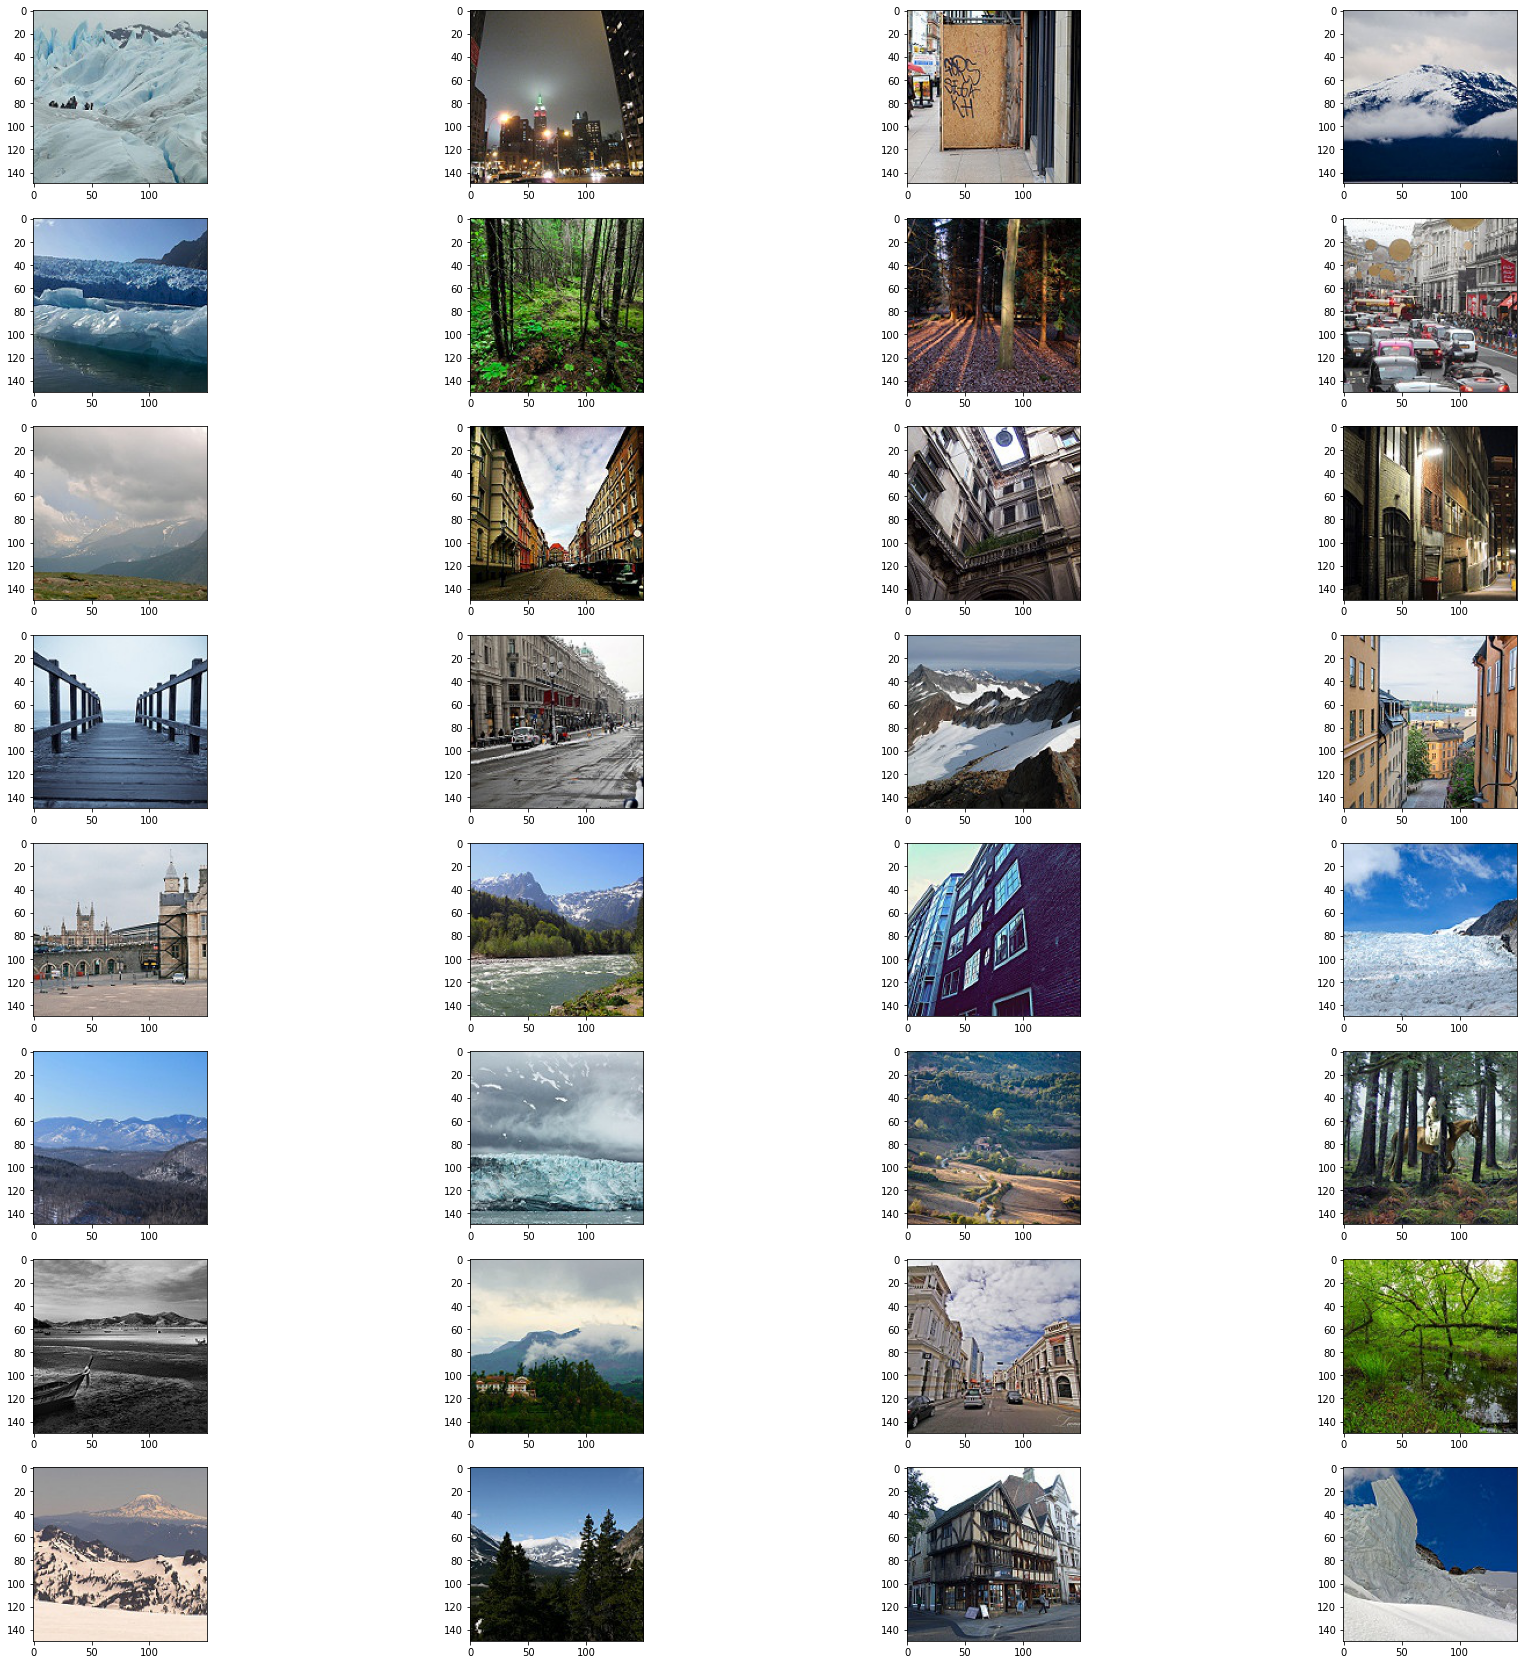

In [0]:
 %matplotlib inline

# Plot the images of the chosen batch to see the classes
# Remember, the classes are the following

# buildings: 1
# forest: 2
# glacier: 3
# mountain: 4
# sea: 5
# street: 6

f = plt.figure(figsize=(30,30))

for i in range(img_batch):
  img = test_batch1[i, :, :, :]
  plt.subplot(8, 4, i + 1)
  imgplot = plt.imshow(img)

plt.show()

In [0]:
 # Make class prediction on the chosen batch
 class_prediction = model.predict(test_batch1, batch_size = img_batch)

 print(class_prediction.shape)

(32, 6)


In [0]:
# Output the list of predicted classes and compare them with the images
# Note: we do not have class labels for the test set. 
# This is why you will need to compare the predicted relult by eye.
import numpy as np
classes_in_bach = []

for i in range(len(class_prediction)):
  cl = np.argmax(class_prediction[i]) + 1
  classes_in_bach.append(cl)

print(classes_in_bach)

[3, 6, 6, 4, 3, 2, 2, 6, 4, 6, 1, 6, 1, 6, 3, 6, 1, 4, 1, 3, 4, 3, 4, 2, 5, 4, 6, 2, 4, 4, 1, 3]


### Well, the result looks really good ;)